In [1]:
# regular expressions
import re 

# math and data utilities
import numpy as np
import pandas as pd
import scipy.stats as ss
import itertools

# ML and statistics libraries
import scipy.stats as stats
import sklearn.preprocessing as pre
from sklearn import model_selection
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Set-up default visualization parameters
mpl.rcParams['figure.figsize'] = [10,6]
viz_dict = {
    'axes.titlesize':18,
    'axes.labelsize':16,
}
sns.set_context("notebook", rc=viz_dict)
sns.set_style("darkgrid")
sns.set_palette(sns.color_palette("GnBu_r", 19))

# Exploratory Data Analysis of Home Prices 

This notebook will focus primarily on EDA and missing value imputation. I'm going to hide most of the code, so that it doesn't detract attention from the analysis. Additionally, this analysis will only cover a select subset of the 79 variables in the dataset. My goal is to outline a process for building an intuition as to what variables are at play, and which have the greatest impact on sale price. After this analysis is complete, I will move on to predictive modeling.

Because predicting home prices is a regression problem, I'll be focusing my analysis on the following ideas (in no particular order):
 - __Variable Distributions__ - We will want to make sure that our continuous variables are normally distributed for the purposes of having well formed data to feed to our regression model. This includes our target variable, __SalePrice__.
 - __Finding and Dealing with Missing Data__ - In this final phase, we will analyze what variables have missing values, why they are missing and how we might deal with the missing data. For example, we will see that the variable __PoolQC__ which describes pool quality and condition has the majority of its entries missing. Should we keep the variable? Perhaps it is missing data, because it is associated with homes that don't have pools. Or should we drop it? Or create a new variable that simply describes "Has Pool" in a yes or no sort of way. 
 - __Linearity of Continuous Variables__. If our variables have linear relationships with Sale Price, then when we get new, unseen data on for sale homes, the final sale price will be easier to predict. If our data does not have a linear relationship, then we must either transform the data, or consider non-linear regression models for prediction.
 - __Strength of association.__ Provided that a variable is related to Sale Price, how strong is that relationship? In other words, is a particular variable worth keeping or not? Often this can only be answered by making predictions with AND without the variable in question, then checking the accuracy of the prediction. Our analysis will simply give us an idea of what variables to experiment with.
 - __ANOVA F-Test of categorical variables against sale price.__ Unlike continuous variables, we can not necessarily determine traditional linear relationships between categories and continuous data. For example, we might easily be able to say "The more little Timmy studies (variable X) the better his test scores (variable Y)". However, let's say little Timmy has 3 math books to choose from and must study for an upcoming test. Now, variable X has possible values of book A, book B, or book C, while variable Y is still his test score. Because the books have no underlying rank or order, we cannot give them meaning through numbers. Without order, linear relationships are impossible. Instead we will use the idea of variance of outcome, based on textbook. Through ANOVA, we may look at the outcome of Timmy's test scores after using each of three books. While there may be differences between his test scores, we must dig deep to find out if those differences can really be attributed to his choice of study material. 



In [2]:
train_df = pd.read_csv('data/train.csv', index_col='Id')
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Distribution of Target Variable:

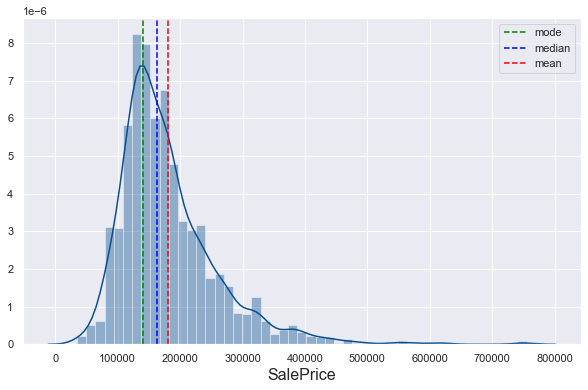

In [3]:
sigma = train_df.SalePrice.std()
mu = train_df.SalePrice.mean()
med = train_df.SalePrice.median()
mode = train_df.SalePrice.mode().to_numpy()

sns.distplot(train_df.SalePrice)
plt.axvline(mode, linestyle='--', color='green', label='mode')
plt.axvline(med, linestyle='--', color='blue', label='median')
plt.axvline(mu, linestyle='--', color='red', label='mean')
plt.legend()

Our response variable appears to be right skewed, so is a candidate for log transformation. Below we see that log(y+1) provides a nice distribution. We will keep this distribution in mind for use in a `TransformedTargetRegressor` when it is time to make predictions.

testing a log transformation supplies a much more normal distribution:

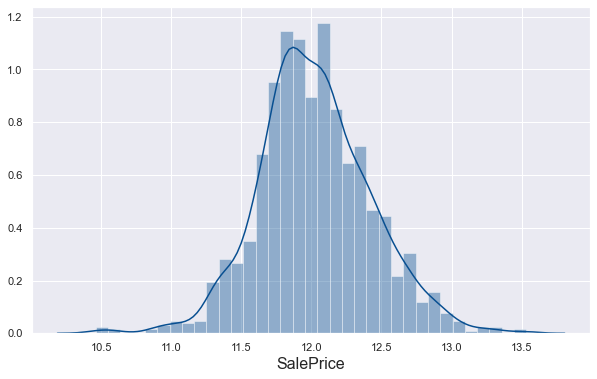

In [4]:
sns.distplot(np.log1p(train_df.SalePrice), kde=True)

Let's get warmed up with a check our intuition that it's not just quantity but quality that counts toward final sale price:

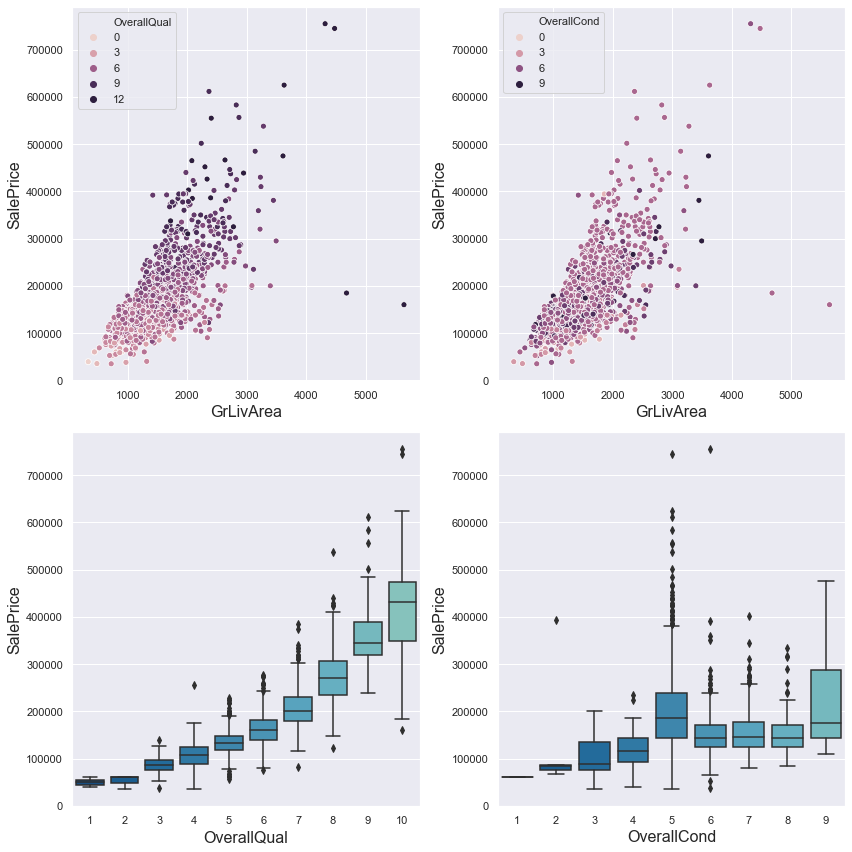

In [5]:
fig, axes = plt.subplots(2,2, figsize=(12,12))
sns.scatterplot(x='GrLivArea', y='SalePrice', hue='OverallQual', data=train_df, ax=axes[0,0])
sns.scatterplot(x='GrLivArea', y='SalePrice', hue='OverallCond', data=train_df, ax=axes[0,1])
sns.boxplot(x='OverallQual', y='SalePrice', data=train_df, ax=axes[1,0])
sns.boxplot(x='OverallCond', y='SalePrice', data=train_df, ax=axes[1,1])
plt.tight_layout()

It appears that sale price is graduated not only by above ground living area but also by quality of material and finish (described by __OverallQual__). Surprisingly, it appears that overall condition (__OverallCond__) is rather well mixed. The box plots do show negative skew (towards lower price) in below average condition homes and positive skew (towards higher price) in above average condition homes, but nothing to write home about. There are also a large number of outliers in the category 5 (average condition) of __OverallCond__. This may contribute to the disorder.

Also notice the two outliers, homes with relatively large square footage, plus high quality materials, above average condition which sold ___well___ below average. We will likely discount these outliers for purposes of making predictions.

In a while, we will run through some of the other most intuitive predictors of home sale prices, looking for correlation to our response variable (sale price). We will use both standard univariate correlation, and later residual plots to test our assumptions of linearity. Before all of that, though, I'd like to address our missing data and figure out a bit more about what our data has to tell us.

## Checking For and Dealing With Missing Data

Our next round of analysis will focus on our missing data. We want to know why the data is missing, and how we might be able to fill in the blanks. For example, data might be missing for a home's basement simply because the home doesn't have a basement. The data dictionary that came with this dataset shows that, for most variables, the value "NA" signifies that the home does not have the feature in question. It may simply come down to mis-recorded values. In those cases we simply need to change "NaN" to "NA" (or 0, if we've already label encoded the variable). 

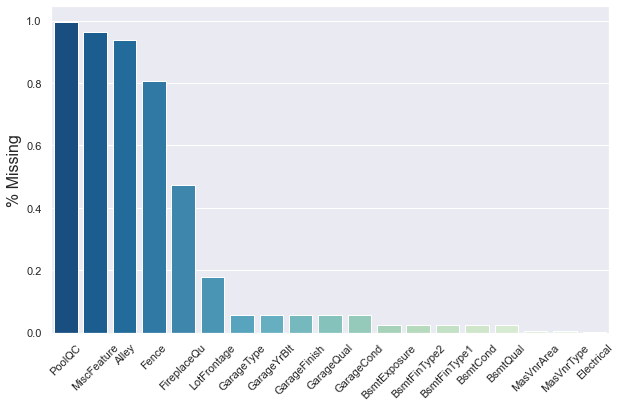

In [6]:
def viz_missing():

    missing = pd.DataFrame({
        'Missing':train_df.isnull().sum(),
        '% Missing': train_df.isnull().sum()/len(train_df)
    })
    missing = missing[missing['% Missing'] > 0].sort_values(by='Missing', ascending=False)
    sns.barplot(x=missing.index, y='% Missing', data=missing)
    plt.xticks(rotation=45)
    plt.show()

viz_missing()

__FireplaceQu__ (Fireplace Quality) is the first variable with less than 50 percent missing data. The __Fireplaces__ (# of fireplaces variable)  has a possible value of "NA - No Fireplace". Perhaps these entries are associated with the missing data in the quality description.

In [7]:
nofire_na = train_df.loc[train_df.FireplaceQu.isna() &
                         (train_df.Fireplaces == 0)].shape[0]

In [8]:
train_df.FireplaceQu.isna().sum(), nofire_na

(690, 690)

So indeed, all 690 instances of missing data in __FireplaceQu__ are associated with homes that don't have fireplaces. According to the variable description, these values should be "NA" not "NaN". We will fix that now:

In [9]:
train_df.FireplaceQu.fillna('NA', inplace=True)

I'd like to do the same check on the variable __PoolQC__. My educated guess is that a pool adds significant value to a home, but with so much missing data, it's going to be hard to determine if my intuition is correct.

In [10]:
pool_na = train_df.loc[train_df.PoolQC.isna() & (train_df.PoolArea == 0)].shape[0]
pool_na, train_df.PoolQC.isna().sum()

(1453, 1453)

Note that there is no missing data for the variable __PoolArea__, and there are exactly 1453 entries where pool area is 0 square feet. This matches our 1453 missing entries for __PoolQC__. According to the data dictionary, the variable for pool quality and condition should be "NA" for those homes that have no pool. Since this is not the case, we will fill in those missing entries with "NA".

In [11]:
train_df.PoolQC.fillna("NA", inplace=True)

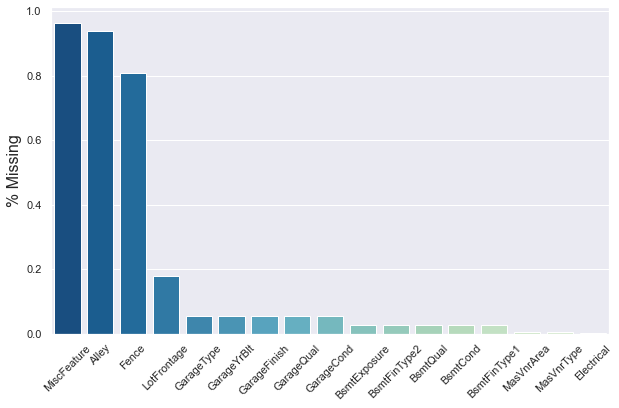

In [12]:
viz_missing()

In [13]:
train_df.MiscFeature.value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

In [14]:
train_df.MiscFeature.fillna("NA", inplace=True)

49 homes have sheds, two have a second garage and on has a tennis court. These are very different features, and so this variable may not be particularly useful. A shed will obviously add less value to a home than a tennis court. It might be worth one-hot encoding variables such as these so that their data can be made available to a machine learning algorithm. Or, alternatively, we can extract these features and add them as their own variables. As it stands, I believe most algorithms would have a hard time with data such as this. We'll get to that when we are done dealing with our missing data.

For our two remaining continuous variable, __LotFrontage__ and __MasVnrArea__ we will fill the missing data points with the median (chosen over mean because it is more robust to outliers in the data.

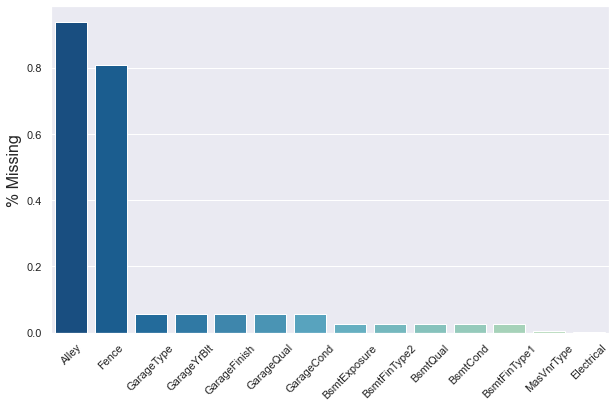

In [15]:
train_df.MasVnrArea.fillna(train_df.MasVnrArea.median(), inplace=True)
train_df.LotFrontage.fillna(train_df.LotFrontage.median(), inplace=True)
viz_missing()

In [16]:
for var in ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']:
    print(train_df[var].isna().sum())

81
81
81
81
81


It appears that all variables which describe a home's garage have the same amount of missing data. This implies to me that the homes associated with these missing data points do not have a garage. Each of these variables should read "NA" if there is no garage with the home. The only exception is __GarageYrBlt__, which we will have to figure something else out for.

In [17]:
for var in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    train_df[var].fillna("NA", inplace=True)
    

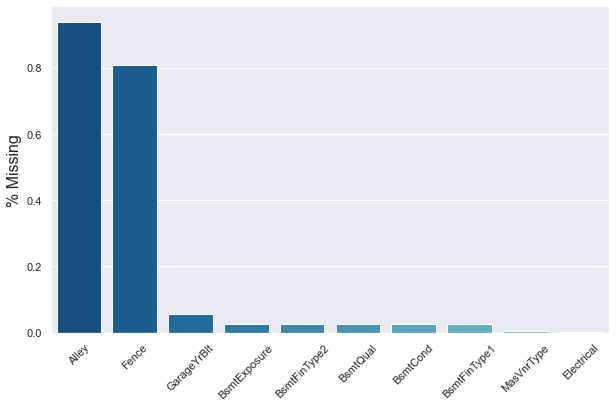

In [18]:
viz_missing()

In [19]:
for var in ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond']:
    print(train_df[var].isnull().sum())

38
37
38
37
37


The values don't quite match, so let's take a closer look at the data, just in case the missing values are dissociated from one another. 

In [20]:
# Are all of the missing values associated with one another? 
train_df.loc[train_df.BsmtExposure.isna(), ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond']]

,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,BsmtCond
Id,,,,,
18,NaN,NaN,NaN,NaN,NaN
40,NaN,NaN,NaN,NaN,NaN
91,NaN,NaN,NaN,NaN,NaN
103,NaN,NaN,NaN,NaN,NaN
157,NaN,NaN,NaN,NaN,NaN
183,NaN,NaN,NaN,NaN,NaN
260,NaN,NaN,NaN,NaN,NaN
343,NaN,NaN,NaN,NaN,NaN
363,NaN,NaN,NaN,NaN,NaN


With the exception of entry 949, missing basement data can also be chocked up to the home having no basement. Again, we will fill in the missing data with 'NA'.

In [21]:
for var in ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond']:
    train_df[var].fillna('NA', inplace=True)
    

In [22]:
train_df[['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond']].isna().sum()

BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
BsmtQual        0
BsmtCond        0
dtype: int64

In [23]:
train_df.BsmtFinType2.value_counts()

Unf    1256
Rec      54
LwQ      46
NA       38
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

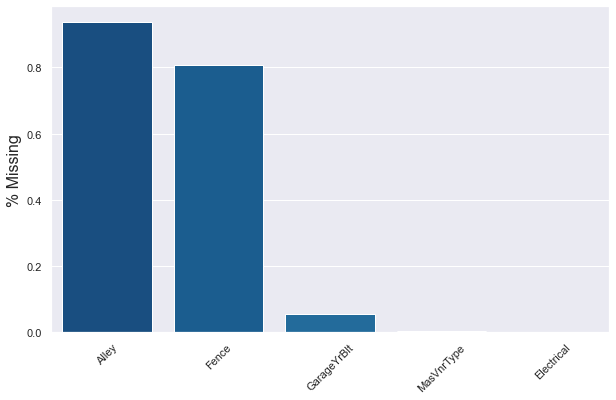

In [24]:
viz_missing()

For the variable __GarageYrBlt__, for any missing data points, I will assume that the garage was built in the same year as the home. For __MasVnrType__ and __Electrical__, I will fill the missing values with the mode of the existing data. The final two variables __Alley__ and __Fence__ I intend to drop completely from the analysis.

In [25]:
train_df.loc[train_df.GarageYrBlt.isna(), 'GarageYrBlt'] = train_df.YearBuilt
train_df.MasVnrType.fillna('None', inplace=True) # fill with mode
train_df.Electrical.fillna('Sbrkr', inplace=True)

In [26]:
train_df = train_df.drop(['Alley', 'Fence'], axis=1)

# Feature Engineering

In order to make good predictions, our variables should describe the underlying factors that influence home prices. Sometimes, the data we are handed can be improved by taking a new view. For example, a given variable like __MisFeature__ may provide good information in a 'between the lines' sort of way. It has the following possible values:

       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	  None

From this variable we can ascertain whether or not a home has a large shed, or even a tennis court. But a large shed and a tennis court are two entirely different entities. A tennis court almost certainly adds more value to a home than a shed or a second garage. To bring that information to the forefront, we can split __MiscFeature__ into separate variables like __HasShed__, __HasTennis__, etc. While a predictive algorithm often can pick up on underlying information on its own, bringing these variables to the forefront make it more likely the model will succeed.

Below, I am adding some features to the data that I think may be useful:

In [27]:
# Create variables that signify home has ____ feature.

train_df['HasShed'] = train_df.MiscFeature.apply(lambda x: 1 if x == 'Shed' else 0)
train_df['HasTennis'] = train_df.MiscFeature.apply(lambda x: 1 if x == 'TenC' else 0)
train_df['HasGar2'] = train_df.MiscFeature.apply(lambda x: 1 if x == 'Gar2' else 0)
train_df['HasPool'] = train_df.PoolArea.apply(lambda x: 1 if x > 0 else 0)
train_df['HasDeck'] = train_df.WoodDeckSF.apply(lambda x: 1 if x > 0 else 0)
train_df['IsNew'] = train_df.YearBuilt.apply(lambda x: 1 if x > 2000 else 0)
train_df['IsOld'] = train_df.YearBuilt.apply(lambda x: 1 if x < 1946 else 0)
train_df.drop(['MiscFeature'], axis=1, inplace=True)

In [28]:
porch_area = ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
train_df['HasPorch'] = train_df.loc[:, porch_area] \
                            .sum(axis=1) \
                            .apply(lambda x: 1 if x > 0 else 0)

In [29]:
train_df[['HasPorch']+porch_area].sort_values(by='HasPorch')

,HasPorch,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch
Id,,,,,
868,0,0,0,0,0
686,0,0,0,0,0
364,0,0,0,0,0
1209,0,0,0,0,0
362,0,0,0,0,0
...,...,...,...,...,...
562,1,38,0,0,0
561,1,0,0,0,95
560,1,20,0,0,0


In [30]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,SaleCondition,SalePrice,HasShed,HasTennis,HasGar2,HasPool,HasDeck,IsNew,IsOld,HasPorch
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,Normal,208500,0,0,0,0,0,1,0,1
2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,Normal,181500,0,0,0,0,1,0,0,0
3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,Normal,223500,0,0,0,0,0,1,0,1
4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,Abnorml,140000,0,0,0,0,0,0,1,1
5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,Normal,250000,0,0,0,0,1,0,0,1


# Strength of Relationships Between Variables

At this point, we have filled in all of our missing data, and come up with some new ways to describe our homes in question. With a full dataset, we are almost ready to apply deeper statistical analysis of our data. However, in order to model our data's relationships, we must first convert our non-numeric data to number format.  

We will split our variables into their three types: __continuous, ordinal and nominal__.
 - __Continuous__ : variables whose values are on a continuous range, typically with an infinite number of possible values. Examples include a child's height, speed, or depth. 
 - __Ordinal__ : variables whose values are discrete and finite, but which have underlying order. A variable that classifies disease severity into 'mild', 'moderate' and 'severe' is one such example. Only three values, non-continuous, but with an underlying rank.
 - __Nominal__ : variables whose values are discrete categories with no underlying order. One such example might be the variable sex, which contains the categories 'Male' and 'Female'. 

In [31]:
# a selection of variables that I expect to add to home value and/or curbside appeal, by variable type
exp_ordinal = ['ExterQual', 'BsmtQual', 'GarageQual', 
               'KitchenQual', 'FireplaceQu', 'PoolQC',  
               'OverallQual', 'ExterCond', 'BsmtCond', 
               'GarageCond', 'OverallCond', 'HeatingQC',
               'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
               'GarageCars', 'GarageFinish', 'BedroomAbvGr', 
               'KitchenAbvGr', 'HouseStyle', 'TotRmsAbvGrd',
               'YearBuilt', 'MoSold', 'YrSold', 'MasVnrArea', 
               'Utilities', 'BsmtFullBath', 'BsmtHalfBath', 
               'FullBath', 'HalfBath', 'CentralAir', 
               'YearRemodAdd','LotShape', 'Functional']

exp_nominal = ['Neighborhood', 'MSZoning', 'Condition1', 
               'Condition2', 'GarageCars', 'RoofStyle', 
               'RoofMatl', 'Exterior1st', 'Exterior2nd', 
               'MasVnrType', 'Foundation', 'Electrical', 
               'SaleType', 'SaleCondition', 'HasShed',
               'HasTennis', 'HasGar2', 'HasPorch', 
               'HasDeck', 'HasPool', 'GarageType', 
               'LotConfig', 'PavedDrive', 'IsOld', 'IsNew']

exp_contin  = ['LotArea', 'LotFrontage', 'GrLivArea', 
               'GarageArea', 'BsmtFinSF1', 'BsmtFinSF2', 
               'TotalBsmtSF', 'BsmtUnfSF', '1stFlrSF', 
               '2ndFlrSF', 'LowQualFinSF', 'WoodDeckSF', 
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
               'PoolArea', 'MiscVal', 'SalePrice']

### Converting Ordinal Variables to Numbers:

Almost all "Quality and Condition" variables share the same letter code scheme in the data: 

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

Some variables like __BsmtCond__ (Basement Condition) have an additional category (NA - No Basement). We will encode these as integers from 0 to 5 in increasing quality or condition.

In [32]:
qual_map = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 
             'BsmtCond', 'HeatingQC', 'KitchenQual', 
             'FireplaceQu', 'GarageQual', 'GarageCond',
             'PoolQC']

for col in qual_vars:
    train_df[col] = train_df[col].map(qual_map)
    
# Make sure we see all numeric data:    
train_df[qual_vars]

,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC
Id,,,,,,,,,,
1,4,3,4,3,5,4,0,3,3,0
2,3,3,4,3,5,3,3,3,3,0
3,4,3,4,3,5,4,3,3,3,0
4,3,3,3,4,4,4,4,3,3,0
5,4,3,4,3,5,4,3,3,3,0
...,...,...,...,...,...,...,...,...,...,...
1456,3,3,4,3,5,3,3,3,3,0
1457,3,3,4,3,3,3,3,3,3,0
1458,5,4,3,4,5,4,4,3,3,0


Next, let's take care of some of the basement and garage qualitative variables that don't follow the above mold:

In [33]:
# Map basement quality variables in ascending order of quality

train_df.BsmtExposure = train_df.BsmtExposure.map({
       'Gd':4,
       'Av':3,
       'Mn':2,
       'No':1,
       'NA':0
})

train_df.BsmtFinType1 = train_df.BsmtFinType1.map({
    'NA': 0,
    'Unf': 1,
    'LwQ': 2,
    'Rec': 3,
    'BLQ': 4,
    'ALQ': 5,
    'GLQ': 6
})

train_df.BsmtFinType2 = train_df.BsmtFinType2.map({
    'NA': 0,
    'Unf': 1,
    'LwQ': 2,
    'Rec': 3,
    'BLQ': 4,
    'ALQ': 5,
    'GLQ': 6
})     

train_df.GarageFinish = train_df.GarageFinish.map({
    'NA': 0,
    'Unf': 1,
    'RFn': 2,
    'Fin': 3
})

Finally, we will map a few miscellaneous home variables in ascending order of quality:

In [34]:
# Functional Deductions
train_df.Functional = train_df.Functional.map({
    'Sal': 0,
    'Sev': 1,
    'Maj2': 3,
    'Maj1': 4,
    'Mod': 5,
    'Min2': 6,
    'Min1': 7,
    'Typ': 8
})

# Number of available utilities
train_df.Utilities = train_df.Utilities.map({
    'ELO': 0,
    'NoSeWa': 1,
    'NoSewr': 2,
    'AllPub': 3
})

# has central air
train_df.CentralAir = train_df.CentralAir.map({
    'N': 0,
    'Y': 1
})

# irregularity of shape of lot
train_df.LotShape = train_df.LotShape.map({
    'IR3': 0,
    'IR2': 1,
    'IR1': 2,
    'Reg': 3
})

train_df.HouseStyle = train_df.HouseStyle.map({
    '1Story': 1,
    '1.5Unf': 2,
    '1.5Fin': 3,
    '2Story': 4,
    '2.5Unf': 5,
    '2.5Fin': 6,
    'SFoyer': 7,
    'SLvl': 8
})

## Looking at Relationships Between Variables:

Now, we must consider the association between our predictor variables and our response variable. Because we are dealing with a continuous response variable, but have some categorical features, we will have to think carefully about how to measure association. 

### Broad Overview by Heatmap (Ordinal/Ranked and Continuous Data):

We will work first with our ranked/ordinal and continuous variables, as traditional "correlation" is easier to see with these types of variables. This is because correlation, by definition, is a measure of the strength of a linear relationship. Linear relationships only occur among data that can be measured continuously, or discrete data whose levels are evenly spaced in their impact. For the ordinal data, I propose either using Kendall's $\tau$ or descritizing sale prices and using Goodman and Kruskal's $\gamma$. Since Kendall's $\tau$ is included in the scikit learn library, we need not write our own method. 

First, let's take a high level look of all of our candidate variables' relationships with heatmaps:

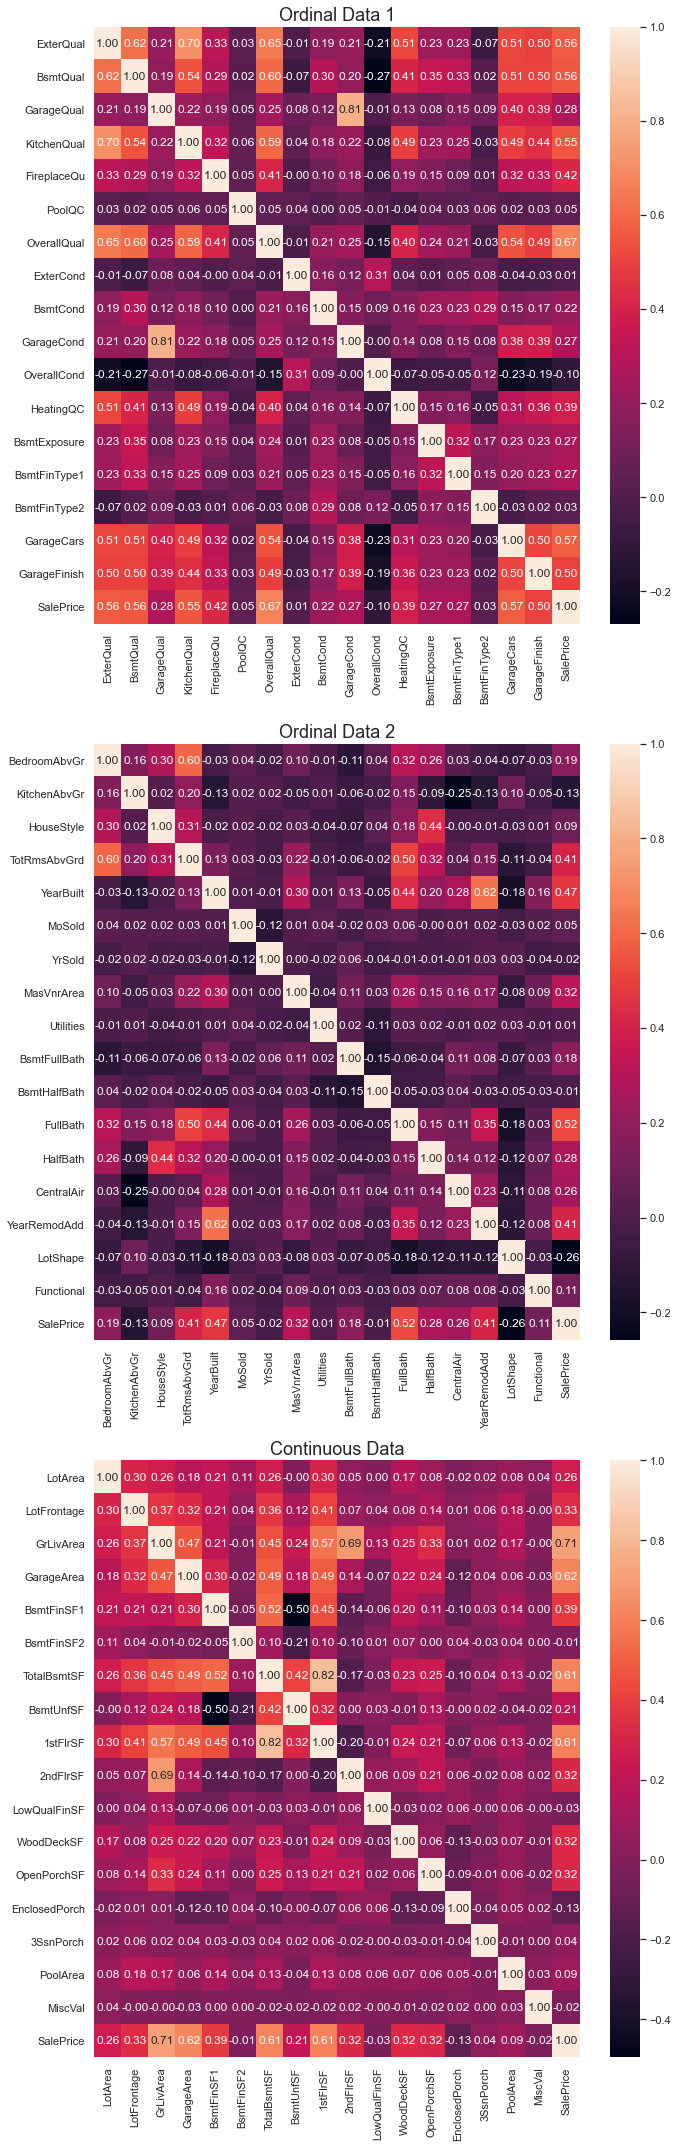

In [35]:
fig, axes = plt.subplots(3, 1, figsize=(10,30))

#Too many variables for a single heatmap of all ordinal data
ord1 = exp_ordinal[0:17] + ['SalePrice']
ord2 = exp_ordinal[17:] + ['SalePrice']

corr1 = train_df[ord1].corr(method='kendall')
corr2 = train_df[ord2].corr(method='kendall')
corr3 = train_df[exp_contin].corr()

sns.heatmap(corr1, annot=True, ax=axes[0], fmt='0.2f').set_title('Ordinal Data 1')
sns.heatmap(corr2, annot=True, ax=axes[1], fmt='0.2f').set_title('Ordinal Data 2')
sns.heatmap(corr3, annot=True, ax=axes[2], fmt='0.2f').set_title('Continuous Data')

plt.tight_layout()
plt.show()

The above broad overview of correlation is interesting in that we see that almost all of the variables at play are somewhat correlated with one another. We appear to have a lot of information that is redundantly encoded in our variables. For example we would expect __TotRmsAbvGr__ would correlate to well to __BedroomAbvGr__, and we see exactly that. Sometimes it is beneficial to drop highly correlated predictor variables because many models operate much more efficiently on independent data. 

### Isolating Predictor vs Response Variable Association:

We want our predictor variables to be highly correlated with our outcome, so we will look at those values individually below:

In [36]:
ord1_corr = pd.DataFrame(
    train_df[ord1].corr().loc['SalePrice']
)
ord1_corr.sort_values(by='SalePrice', inplace=True, ascending=False)

ord2_corr = pd.DataFrame(
    train_df[ord2].corr(method='kendall').loc['SalePrice']
)
ord2_corr.sort_values(by='SalePrice', inplace=True, ascending=False)

cont_corr = pd.DataFrame(
    train_df[exp_contin].corr().loc['SalePrice']
)
cont_corr.sort_values(by='SalePrice', inplace=True, ascending=False)

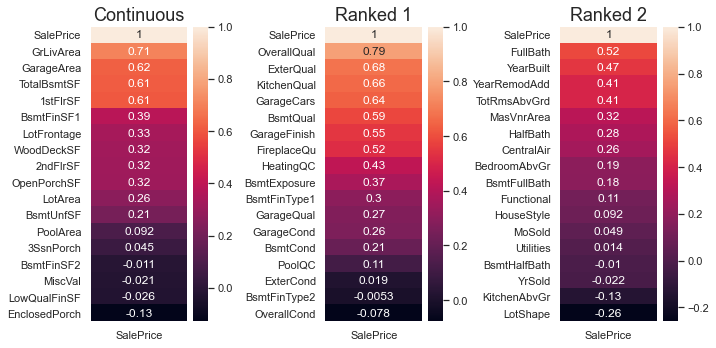

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 5))
sns.heatmap(cont_corr, annot=True, ax=ax1).set_title('Continuous')
sns.heatmap(ord1_corr, annot=True, ax=ax2).set_title('Ranked 1')
sns.heatmap(ord2_corr, annot=True, ax=ax3).set_title('Ranked 2')
plt.tight_layout()
plt.show()

The above graphic describes each predictor variable's correlation to sale price, in descending order. Some interesting relationships stand out, one example being __GarageCars__ being moderately negatively correlated to Sale Price. We see the same interesting reverse correlation between __LotShape__ where apparently sale price tends to go up as the shape of the lot becomes more irregular. 

This view of variable relationships is somewhat naive. When one or two variables are at play, univariate analysis is more trustworthy. However, when we begin to include more variables, there are cases where the apparent (calculated) correlation and the true correlation between the two variables is very much different (sometimes even completely reversed). One such phenomenon is called "Simpson's Paradox".

Additionally, traditional __Pearson's $r$__ correlation typically used for continuous data only measure's linear relationships. 'Spearman's rho ($\rho$)', however is used to detect monotonic increase or decrease, and is therefore better suited to find both linear and non-linear relationships. In fact, if we see that  $\rho$ is much greater than $r$, it is a sign that there is a non-linear relationship between the two variables in question. 



In [38]:
def plot_response_corr(df, features, response, corr_type):
    
    cor = pd.DataFrame()
    width = len(features)*0.5
    height = 5
    fig, ax = plt.subplots(figsize=(width, height))
    
    # Measure difference between Spearman's and Pearson's to analyze for non-linearity
    if corr_type == 's-p':
        
        cor['feature'] = features
        cor['spearman'] = [df[f].corr(df[response], 'spearman') for f in features]
        cor['pearson'] = [df[f].corr(df[response], 'pearson') for f in features]
        cor['comparison'] = cor['spearman'] - cor['pearson']
        
        sns.barplot(
            data=cor.sort_values(by='comparison'), 
            x='feature', y='comparison', ax=ax
        ).set_title('S-P Comparison')
           
    else:
        cor['feature'] = features
        cor[corr_type] = [df[f].corr(df[response], corr_type) for f in features]
        cor = cor.sort_values(corr_type)
        plt.figure(figsize=(len(features)*1.5, 5))
        axes = sns.barplot(data=cor, x='feature', y=corr_type, ax=ax) \
            .set_title(f'{corr_type} Association to Response Variable')        
    

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return cor 

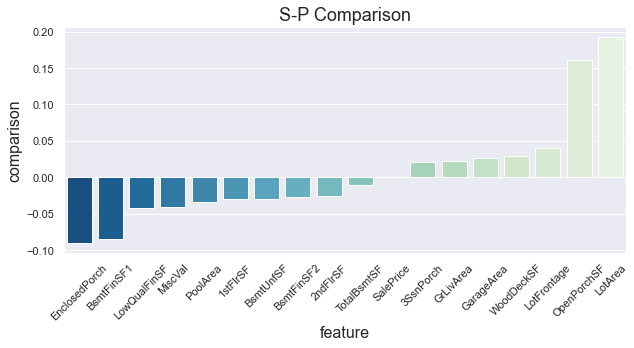

In [39]:
df = plot_response_corr(train_df, exp_contin, 'SalePrice', 's-p')

It appears that __LotArea__ in particular shows moderate difference in Spearman and Pearson measures of association. This may mean that house prices are not related to the lot size in a linear fashion. Perhaps the relationship is polynomial or exponential. 

Below, the same analysis applied to the ordinal data shows moderate difference in 

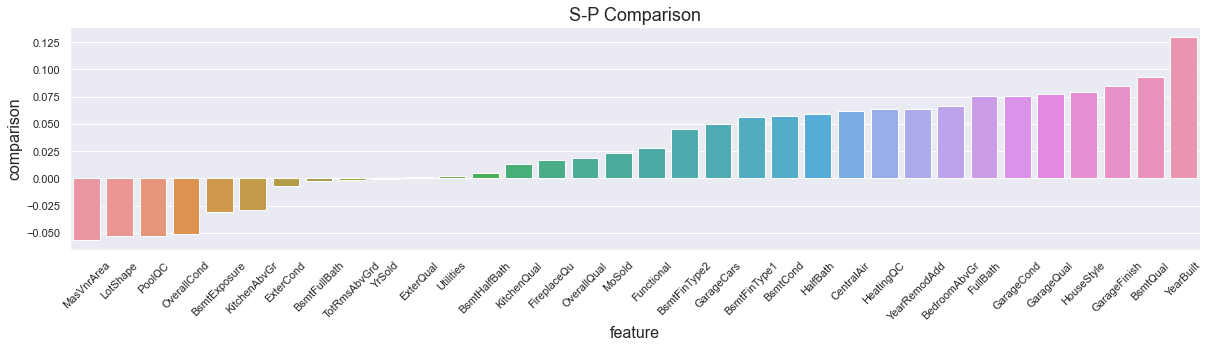

In [40]:
df = plot_response_corr(train_df, exp_ordinal, 'SalePrice', 's-p')

### Categorical Data (Nominal)

For our nominal data, quantitative association is somewhat difficult to achieve in the same way as ordinal and continuous data. We can, however, take a look at box plots for each of our interesting nominal variables. The idea is to look for separation of home values according to category. We are graphically answering questions like _"Is the average cost of a home significantly different between neighborhoods X, Y, and Z?"_.

To refresh our memories on what some of our nominal variables are:

- __Neighborhood__ - What neighborhood is the home located in.
- __MSZoning__ -Identifies the type of zoning (agricultural, commercial, etc.)
- __Condition1 & Condition2__ - Proximity to urban features such as railroads, parks, etc.


### Neighborhood:

I have created a boxplot of neighborhoods ordered by there average home value. Visually, we do see a rough ordering to these neighborhoods. Is this variance in sale price due to differences between neighborhoods, or is it more due to differences within individual neighborhoods (for example, is the mean home value of neigborhood X quite high compared to neighborhood Y because there is a billion dollar mansion at the end of the street, while all the other homes are relatively cheap?). This question cannot be well answered by a graph, and we will address it later. 

In [41]:
# for ordering the boxplots by median
grouped = train_df.loc[:,['Neighborhood', 'SalePrice']] \
    .groupby(['Neighborhood']) \
    .mean() \
    .sort_values(by='SalePrice')

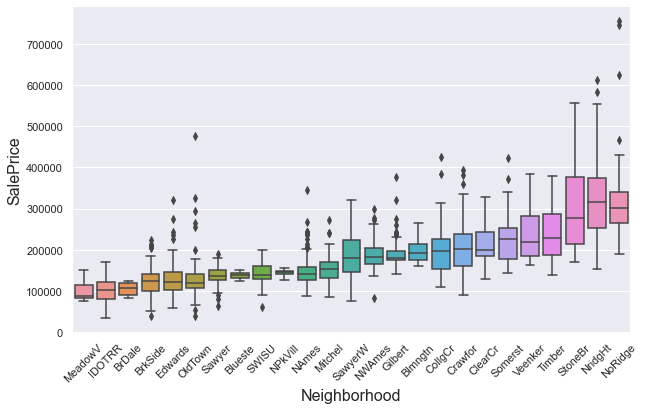

In [42]:
chart = sns.boxplot(x=train_df.Neighborhood, y=train_df.SalePrice, order=grouped.index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

We will perform one way ANOVA on the data to see if this difference between neighborhoods is significant (statistically). It remains to be seen how much weight the adage "location, location, location" carries.

### Zoning

Our data dictionary defines __MSZoning__ as _"Identifies the general zoning classification of the sale."_, with the following possible categories:

       A	 Agriculture
       C	 Commercial
       FV	Floating Village Residential
       I	 Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

We will apply the same techniques as before to see if we can rank these zones by their average home value.

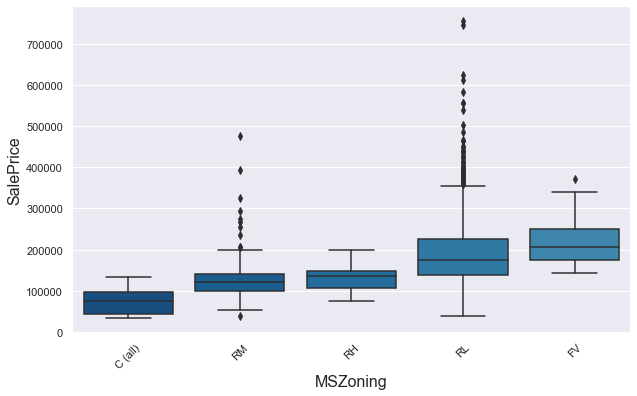

In [43]:
grouped = train_df.loc[:,['MSZoning', 'SalePrice']] \
    .groupby(['MSZoning']) \
    .mean() \
    .sort_values(by='SalePrice')

chart = sns.boxplot(x=train_df.MSZoning, y=train_df.SalePrice, order=grouped.index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

As before, there is visually some separation between the means. We will add it to the 'to-do ANOVA' list.

## Proximity to Urban Features

The __Condition1 & Condition2__ variables describe proximity to the following features such as parks, railroads, etc:

       Artery	Adjacent to arterial street
       Feedr	 Adjacent to feeder street	
       Norm	  Normal	
       RRNn	  Within 200' of North-South Railroad
       RRAn	  Adjacent to North-South Railroad
       PosN	  Near positive off-site feature--park, greenbelt, etc.
       PosA	  Adjacent to postive off-site feature
       RRNe	  Within 200' of East-West Railroad
       RRAe	  Adjacent to East-West Railroad

We will see if we can rank these features as before, but this time we will rank both individual features and every combination of two. 

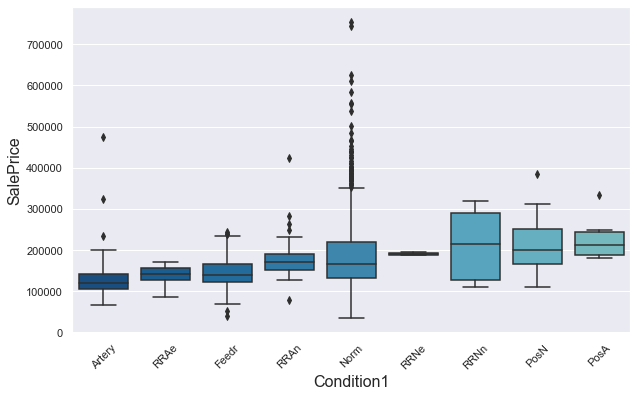

In [44]:
grouped = train_df.loc[:,['Condition1', 'SalePrice']] \
    .groupby(['Condition1']) \
    .mean() \
    .sort_values(by='SalePrice')

chart = sns.boxplot(x=train_df.Condition1, y=train_df.SalePrice, order=grouped.index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

This one doesn't look as promising to me. Again, only a test will tell. Let's go ahead and run such a test on all of these questionable categories. While we have already seen clear association between ordinal variables and __SalePrice__ we will include them in this analysis as well. 

### Performing Analysis of Variation (ANOVA)

While visual inspection of our nominal variables by boxplot is a good start, we need to find out if there is any statistically significant differences between our variable categories when considering sale prices. In order to to answer that question, we will perform ANOVA F-testing to each variable. What this test tells us is, given a variable like __Neighborhood__, is the variance in price that we see across neighborhoods due more to variance between neighborhoods or more from variance within neighborhoods. 

In [45]:
def anova(df, predictor, target, alpha=0.05):
    
    # get unique, indendant treatments (categories in predictory)
    treatments = df.loc[df[predictor].notnull(), predictor].unique()
    group_values = []
    
    # group target variable by category
    for t in treatments:
        group_values.append(df.loc[df[predictor] == t, target].to_numpy())
    
    # calculate degrees of freedom and confidence level
    k = len(treatments)
    n = df[predictor].notnull().sum()
    conf = 1 - alpha
    df1 = k - 1
    df2 = n - k
    
    # calculate critical value of F-distribution
    crit_val = stats.f.ppf(conf, df1, df2)
    
    # calculate F and p-values
    f, p = stats.f_oneway(*group_values)
    
    return f, p, crit_val

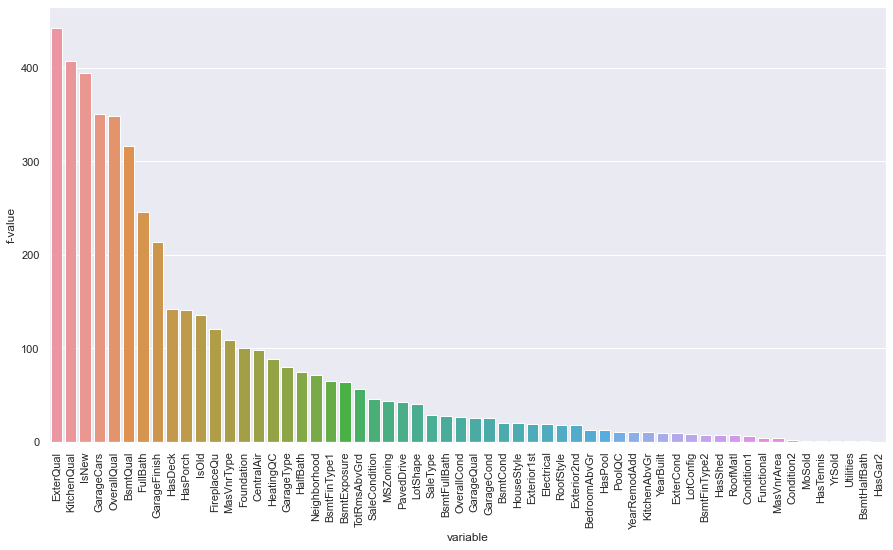

,variable,p-value,f-value,critical,passed
47,MoSold,0.483352,0.957865,1.795249,False
15,HasTennis,0.384569,0.756500,3.847845,False
48,YrSold,0.630089,0.645525,2.378044,False
50,Utilities,0.584717,0.298804,3.847845,False
52,BsmtHalfBath,0.801374,0.221461,3.001900,False
16,HasGar2,0.856292,0.032808,3.847845,False


In [67]:
# DataFrame to hold ANOVA results.
f_frame = pd.DataFrame(columns=['variable','p-value','f-value', 'critical', 'passed'])

# Perform ANOVA on each variable. Store data for plotting
for var in exp_nominal+exp_ordinal:
    f, p, c = anova(train_df, var, 'SalePrice')
    f_frame.loc[len(f_frame)] = [var, p, f, c, (f > c)]

# Plot test results
f_frame.sort_values(by='f-value', ascending=False, inplace=True)

sns.set(rc={'figure.figsize':(15,8)})
sns.barplot(x='variable', y='f-value', data=f_frame)
plt.xticks(rotation=90)
plt.show()

### Summary of ANOVA

What is difficult to see in the visualization is that almost all of our variables passed their F-Test with flying colors. This signifies that there is significant variation in sale price by category within each variable. Those variables that failed the test are below. They may be candidates for dropping before we proceed with predictive modeling. 

In [68]:
f_frame.loc[f_frame.passed == False]

,variable,p-value,f-value,critical,passed
47,MoSold,0.483352,0.957865,1.795249,False
15,HasTennis,0.384569,0.756500,3.847845,False
48,YrSold,0.630089,0.645525,2.378044,False
50,Utilities,0.584717,0.298804,3.847845,False
52,BsmtHalfBath,0.801374,0.221461,3.001900,False
16,HasGar2,0.856292,0.032808,3.847845,False


It does appear that __Condition1__ holds more data than __Condition2__.

## Summary of EDA:

We've looked at a lot. Here is a summary:

### Continuous Data

There is moderate to high correlation between sale price and the features describing lot size, above ground living area and garage size. Additionally, while the association appears to be linear in above grade living area and garage area. However, there is some indication of a non-linear relationship between lot area and sale price. It might be worth investigating, and is an indicator that the data needs to be transformed before applying machine learning. 

We did not look deeply at the correlation between independent variables. 

### Categorical Data (Ordinal)

Most of our intuitions proved to be at least somewhat correct. 

A couple notable exceptions are the low association between __SalePrice__ and __ExterCond__, which was unexpected.

Additionally, there is an inverse association with __OverallCond__. This seems to indicate that better overall condition of a home negatively impacts sale price. In my mind, there are a couple possible explanations:
- First, perhaps the variable is encoded such that higher numbers mean worse condition. (On looking at the encoding, this is not the case
- Second, correlation/association at a univariate level is not necessarily an indicator of association when there are more variables or higher dimensions to the data. With almost 80 variables at play, this is a possibility. 

### Categorical Data (Nominal)

Again, almost all of our assumptions checked out statistically. It appears to me that the variables we covered impact final sale price of homes in Ames, Iowa.

### Converting Nominal Data to Numbers:

Our nominal data is unordered, so we will use the Pandas `factorize()` method to convert our ordinal data. Each category within a variable will be assigned a random integer. 

In [35]:
# for var in exp_nominal:
#     train_df[var], _ = pd.factorize(train_df[var])
    
# train_df[exp_nominal]

,Neighborhood,MSZoning,Condition1,Condition2,GarageCars,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,...,HasTennis,HasGar2,HasPorch,HasDeck,HasPool,GarageType,LotConfig,PavedDrive,IsOld,IsNew
Id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,1,1,1,...,0,0,1,1,0,0,1,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,1,0,0,2,2,1,...,0,0,0,0,0,1,2,0,1,1
5,3,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,17,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1457,6,0,0,0,0,0,0,7,4,2,...,0,0,1,1,0,0,0,0,0,1
1458,2,0,0,0,2,0,0,6,6,1,...,0,0,0,0,0,0,0,0,1,1


In [97]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")